## Project 2: Ames housing price prediction
---
Project notebook organisation:<br>
**1_DataCleaning and FeatureEngineering** (current notebook)<br>
<a href='./2_Regression_Models.ipynb'>2 Regression Models</a><br>
<a href='./3_Visualisation_and_Insights.ipynb'>3 Visualisation and Insights</a><br>

---
### This notebook's layout
<a href='#init'>Initial checks</a><br>
<a href='#clean'>Handling and cleaning of nan(missing/NA) values</a><br>
<a href='#impute'>Impute values for LotFrontage with Regression</a><br>
<a href='#remove'>Removing outliers and redundant columns</a><br>
<a href='#dtype'>Changing some feature's datatype</a><br>
<a href='#test_data'>Cleaning test data</a><br>
<a href='#feature'>Feature Engineering</a><br>
<a href='#encode'>Encode categorical features</a><br>
<a href='#export'>Export cleaned datasets as xls</a><br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import math

sns.set()
%matplotlib inline

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

<a id='init'></a>
### Initial Checks

In [3]:
train.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


There are 2051 observations and 81 variables.

One of the 80 variables is the sale price, and is target variable.

In [4]:
print(train.shape)
print(test.shape)

(2051, 81)
(879, 80)


In [5]:
# Notice the difference between the train and test dataset
list1 = train.columns.tolist()
list2 = test.columns.tolist()
list_difference = []

[list_difference.append(item) for item in list1 if item not in list2]
list_difference

['SalePrice']

In [6]:
# Function to rename all columns by removing the spacing within the column name
def rename_col_name(df):
    for col_name in df:
        if " " in col_name:
            temp_col_name = col_name.replace(" ", "")
            df.rename(columns={col_name: temp_col_name}, inplace='True')

In [7]:
# Renaming both train and test data
rename_col_name(train)
rename_col_name(test)

In [8]:
# Check null values and percentages
# I also did a isna() and it returns exactly the same
train_isnull_val = train.isnull().sum().sort_values(ascending = False)
train_isnull_pct = pd.DataFrame(train_isnull_val*100/len(train))
print(train_isnull_val.head(26))
print(train_isnull_pct.head(26))

PoolQC          2042
MiscFeature     1986
Alley           1911
Fence           1651
FireplaceQu     1000
LotFrontage      330
GarageFinish     114
GarageCond       114
GarageQual       114
GarageYrBlt      114
GarageType       113
BsmtExposure      58
BsmtFinType2      56
BsmtFinType1      55
BsmtCond          55
BsmtQual          55
MasVnrType        22
MasVnrArea        22
BsmtHalfBath       2
BsmtFullBath       2
GarageCars         1
GarageArea         1
BsmtUnfSF          1
BsmtFinSF2         1
TotalBsmtSF        1
BsmtFinSF1         1
dtype: int64
                      0
PoolQC        99.561190
MiscFeature   96.830814
Alley         93.174061
Fence         80.497318
FireplaceQu   48.756704
LotFrontage   16.089712
GarageFinish   5.558264
GarageCond     5.558264
GarageQual     5.558264
GarageYrBlt    5.558264
GarageType     5.509508
BsmtExposure   2.827889
BsmtFinType2   2.730375
BsmtFinType1   2.681619
BsmtCond       2.681619
BsmtQual       2.681619
MasVnrType     1.072647
MasVnrAre

<a id='clean'></a>

###  Handling and cleaning of nan(missing/NA) values 

|      | Feature      | type    | data value      | counts | Remarks                                                      |
| ---- | ------------ | ------- | --------------- | ------ | :----------------------------------------------------------- |
| 1    | PoolQC       | object  | nan(missing/NA) | 2042   | PoolArea  has 2042 values of Zero     SO ok to replace all values with NA |
| 2    | MiscFeature  | object  | nan(missing/NA) | 1986   | Replace all values  with NA                                  |
| 3    | Alley        | object  | nan(missing/NA) | 1911   | Replace all values  with NA                                  |
| 4    | Fence        | object  | nan(missing/NA) | 1651   | Replace all values  with NA                                  |
| 5    | FiReplaceQu  | object  | nan(missing/NA) | 1000   | Replace all values  with NA                                  |
| 6    | LotFrontage  | float64 | nan(missing/NA) | 330    | 330  missing values(16%)     These values obtained via linear regression     with 'LotArea' and '1stFlrSF' as predictors |
| 7    | GarageFinish | object  | nan(missing/NA) | 114    | Replace all values  with NA                                  |
| 8    | GarageCond   | object  | nan(missing/NA) | 114    | Replace all values  with NA                                  |
| 9    | GarageQual   | object  | nan(missing/NA) | 114    | Replace all values  with NA                                  |
| 10   | GarageYrBlt  | float64 | nan(missing/NA) | 114    | All  5 x114 rows indicate there is no garage     Replaces with zero since no garage |
| 11   | GarageType   | object  | nan(missing/NA) | 113    | Replace all values  with NA since no garage                  |
| 12   | BsmtExposure | object  | nan(missing/NA) | 58     | Replace all values  with NA                                  |
| 13   | BsmtFinType2 | object  | nan(missing/NA) | 56     | Replace all values  with NA                                  |
| 14   | BsmtFinType1 | object  | nan(missing/NA) | 55     | Replace all values  with NA                                  |
| 15   | BsmtCond     | object  | nan(missing/NA) | 55     | Replace all values  with NA                                  |
| 16   | BsmtQual     | object  | nan(missing/NA) | 55     | Replace all values  with NA                                  |
| 17   | MasVnrType   | object  | nan(missing/NA) | 22     | 22  missing values of 'MasVnrType' coincide with 22 missing values for  'MasVnrArea'As such, it is safe to assume None for 'MasVnrType' and zero for 'MasVnrArea'. |
| 18   | MasVnrArea   | float64 | nan(missing/NA) | 22     | see above, Replace  values with zero                         |
| 19   | BsmtHalfBath | float64 | nan(missing/NA) | 2      | Insignificant,  Replace values with zero                     |
| 20   | BsmtFullBath | float64 | nan(missing/NA) | 2      | Insignificant,  Replace values with zero                     |
| 21   | GarageCars   | float64 | nan(missing/NA) | 1      | Insignificant,  Replace values with zero                     |
| 22   | GarageArea   | float64 | nan(missing/NA) | 1      | Insignificant,  Replace values with zero                     |
| 23   | BsmtUnfSF    | float64 | nan(missing/NA) | 1      | Insignificant,  Replace values with zero                     |
| 24   | BsmtFinSF2   | float64 | nan(missing/NA) | 1      | Insignificant,  Replace values with zero                     |
| 25   | TotalBsmtSF  | float64 | nan(missing/NA) | 1      | Insignificant,  Replace values with zero                     |


In [9]:
# Creates 2 lists
# na_list: list of column names where value is null, replace with 'NA'
# zero_list: list of column names where value is null, replace with 0
# 'BsmtFinSF1' was manually added based on post-checks into 'zero_list'

na_list = [
'PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageFinish','GarageCond','GarageQual',
    'GarageType','BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual',
]
zero_list = [
    'GarageYrBlt','MasVnrArea','BsmtHalfBath','BsmtFullBath','GarageCars','GarageArea','BsmtUnfSF',
    'BsmtFinSF2','TotalBsmtSF','BsmtFinSF1'
]
print(len(na_list)) # print the item list to check 
print(len(zero_list)) # print the item list to check 

14
10


In [10]:
for col in zero_list:
    train.loc[train[col].isnull(), col] = 0        

In [11]:
for col in na_list:
    train.loc[train[col].isnull(), col] = 'NA' 

In [12]:
# 'MasVnrType' is the only exceptional where its missing values will be set to 'None'
train.loc[train['MasVnrType'].isnull(), 'MasVnrType'] = 'None'

<a id='impute'></a>
### Impute values for LotFrontage with Regression 

Quick multiple linear regression using Gretl

![Gretl_screen_capture](../misc/Gretl_screen_cap.JPG)

In [13]:
# Which features have the highest correlation to 'LotFrontage'
# This information is subsequent fed to Gretl, whereby i selected 2 interdependent variables
pd.DataFrame(train.corr()['LotFrontage'].sort_values(ascending = False)).head(4)

,LotFrontage
LotFrontage,1.000000
LotArea,0.574024
1stFlrSF,0.463900
GrLivArea,0.383856


In [14]:
train['LotFrontage'].head(10)

0      NaN
1     43.0
2     68.0
3     73.0
4     82.0
5    137.0
6     35.0
7      NaN
8      NaN
9     70.0
Name: LotFrontage, dtype: float64

In [15]:
# Using variables to make equation easier for understanding
LotArea = train['LotArea']
stFlrSF = train['1stFlrSF']
# Multiple linear equation obtain from Gretl
LotFrontage_eqn = 32.1 + 0.00213*LotArea + 0.0143*stFlrSF
# Conditional(when is null) updating the LotFrontage column 
train.loc[train['LotFrontage'].isnull(), 'LotFrontage'] = LotFrontage_eqn

In [16]:
# Post-checks to make sure data cleaning done properly
train_isnull_val = train.isnull().sum().sort_values(ascending = False)
train_isnull_pct = pd.DataFrame(train_isnull_val*100/len(train))
print(train_isnull_val.head(2))
print(train_isnull_pct.head(2))

SalePrice      0
TotalBsmtSF    0
dtype: int64
               0
SalePrice    0.0
TotalBsmtSF  0.0


In [17]:
# Quick look at which would be a good predictor of SalePrice

a = pd.DataFrame(train.corr()['SalePrice'].sort_values(ascending = False))
a.head()

,SalePrice
SalePrice,1.000000
OverallQual,0.800207
GrLivArea,0.697038
GarageArea,0.649897
GarageCars,0.647781


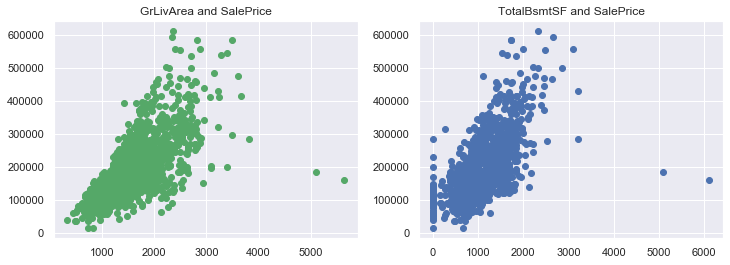

In [18]:
# These are the 2 interdependent variables that were highly correlated to Saleprice
# PLotting them side-by-side, shows the 2 extreme outliers
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
axes[0].scatter(train['GrLivArea'],train['SalePrice'], color='g')
axes[0].set_title('GrLivArea and SalePrice')
axes[1].scatter(train['TotalBsmtSF'],train['SalePrice'], color='b')
axes[1].set_title('TotalBsmtSF and SalePrice')
plt.show()

In [19]:
# The 2 outliers are in fact the same.
train[(train['GrLivArea']>5000)|(train['TotalBsmtSF']>5000)][['SalePrice','GrLivArea','TotalBsmtSF']]

,SalePrice,GrLivArea,TotalBsmtSF
960,160000,5642,6110.0
1885,183850,5095,5095.0


<a id='remove'></a>
### Removing outliers and redundant columns
<p>Remove the 2 extreme outliers.<br/>Although not generally recommended, it is safe to remove them in this case.<br>
These 2 outliers will cause major disprutions to the linear regression.<br>
They are also in stark contrast with the rest, whereby they are largest in area and very low prices at the same time.</p>

The PID (Parcel identification number) does not influence sales price <br>
The column can be safely deleted.<br>

In [20]:
train = train.drop([train.index[960] , train.index[1885]])

In [21]:
train = train.drop(['PID'], axis=1)

<a id='dtype'></a>
### Changing some feature's datatype



| Feature  name | Type    | Range        | Possible      values | description                                         | Sample values  of feature                                    | Change      to | Explanation                                                  |
| ------------- | ------- | ------------ | -------------------- | --------------------------------------------------- | ------------------------------------------------------------ | ---------------- | :----------------------------------------------------------- |
| MSSubClass    | integer | 20 to 190    | 16                   | identifies  the type of dwelling                    | 20  1-STORY 1946 & NEWER ALL STYLES     190 2 FAMILY CONVERSION - ALL STYLES AND AGES | String           | The  magnitude of the number here is not representative of the dwelling type's  coefficient     ('190' does not mean high sales price; similarly,      '20' does not mean low sales price)     Classifying this feature as a string would be more appropriate |
| YrSold        | integer | 2006 to 2010 | 5                    | Year  Sold                                          | 2006,2007…2010                                               | String           | Same explanation as  MSSubClass                              |
| MoSold        | integer | 1 to 12      | 12                   | Month  Sold                                         | 1,2…12                                                       | String           | Same explanation as  MSSubClass                              |
| OverallQual   | integer | 1 to 10      | 10                   | Rates  the overall material and finish of the house | 1:Very  Poor     10:Very Excellent                           | string           | When  integer values are assigned to ordinal categories,      we are imposing the assumption that they are equally spaced.      Use dummy variables to allow the data to make the inference |
| OverallCond   | integer | 1 to 10      | 10                   | Rates  the overall condition of the house           | 1:Very  Poor     10:Very Excellent                           | string           | Same explanation as  OverallQual                             |

In [22]:
# Changing some feature's datatype (see above)
train['MSSubClass'] = train['MSSubClass'].astype(str)
train['OverallQual'] = train['OverallQual'].astype(str)
train['OverallCond'] = train['OverallCond'].astype(str)
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

In [23]:
# Exporting as csv for visalisation part (before encoding)
train.to_csv('../data/train_tableau.csv',index=False)

<a id='test_data'></a>
### Cleaning test data

In [24]:
test_isnull_val = test.isnull().sum().sort_values(ascending = False)
test_isnull_pct = pd.DataFrame(test_isnull_val*100/len(test))
print(test_isnull_val.head(19))
print(test_isnull_pct.head(19))

PoolQC          875
MiscFeature     838
Alley           821
Fence           707
FireplaceQu     422
LotFrontage     160
GarageCond       45
GarageQual       45
GarageYrBlt      45
GarageFinish     45
GarageType       44
BsmtExposure     25
BsmtFinType1     25
BsmtQual         25
BsmtFinType2     25
BsmtCond         25
MasVnrArea        1
MasVnrType        1
Electrical        1
dtype: int64
                      0
PoolQC        99.544937
MiscFeature   95.335609
Alley         93.401593
Fence         80.432309
FireplaceQu   48.009101
LotFrontage   18.202503
GarageCond     5.119454
GarageQual     5.119454
GarageYrBlt    5.119454
GarageFinish   5.119454
GarageType     5.005688
BsmtExposure   2.844141
BsmtFinType1   2.844141
BsmtQual       2.844141
BsmtFinType2   2.844141
BsmtCond       2.844141
MasVnrArea     0.113766
MasVnrType     0.113766
Electrical     0.113766


In [25]:
# Creates overall list of 19 items of all columns with nan(missing/NA)
test_clean_list = [
    'PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage','GarageCond','GarageQual','GarageYrBlt',
    'GarageFinish','GarageType','BsmtExposure','BsmtFinType1','BsmtQual','BsmtFinType2','BsmtCond','MasVnrArea','MasVnrType',
    'Electrical'
]
len(test_clean_list)

19

In [26]:
# builts test_na_list after checking the columns dtype: test[test_clean_list].dtypes
# All columns with null values in this list will be replaced with 'NA', similar to the train dataset
# Only 'Electrical' is different
 
test_na_list = [
    'PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageCond','GarageQual','GarageFinish',
    'GarageType','BsmtExposure','BsmtFinType1','BsmtQual','BsmtFinType2','BsmtCond'
]
len(test_na_list)

14

In [27]:
test['LotFrontage'].head(10)

0    69.0
1     NaN
2    58.0
3    60.0
4     NaN
5    21.0
6    52.0
7     NaN
8    39.0
9    75.0
Name: LotFrontage, dtype: float64

In [28]:
# columns(inside test_na_list) with null are replaced with 'NA'
for col in test_na_list:
    test.loc[test[col].isnull(), col] = 'NA' 
    
# MasVnrArea coincide MasVnrType
test.loc[test['MasVnrType'].isnull(), 'MasVnrType'] = 'None'

# MasVnrArea coincide MasVnrType
test.loc[test['MasVnrArea'].isnull(), 'MasVnrArea'] = 0

# Select the most common value 'SBrkr' since its just single value
test.loc[test['Electrical'].isnull(), 'Electrical'] = 'SBrkr'

# All 5 x 45 rows indicate there is no garage Replaces with zero since no garage
test.loc[test['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 0

In [29]:
# Multiple linear equation obtain from Gretl
LotFrontage_test_eqn = 32.1 + 0.00213*test['LotArea'] + 0.0143*test['1stFlrSF']

test.loc[test['LotFrontage'].isnull(), 'LotFrontage'] = LotFrontage_test_eqn

In [30]:
test['LotFrontage'].head(10)

0    69.00000
1    80.80816
2    58.00000
3    60.00000
4    72.26920
5    21.00000
6    52.00000
7    70.01158
8    39.00000
9    75.00000
Name: LotFrontage, dtype: float64

In [31]:
# The PID (Parcel identification number) does not influence sales price 
# The column can be safely deleted.
test = test.drop(['PID'], axis=1)

In [32]:
test_isnull_val = test.isnull().sum().sort_values(ascending = False)
test_isnull_pct = pd.DataFrame(test_isnull_val*100/len(test))
print(test_isnull_val.head(3))
print(test_isnull_pct.head(3))

SaleType     0
ExterCond    0
RoofStyle    0
dtype: int64
             0
SaleType   0.0
ExterCond  0.0
RoofStyle  0.0


### Changing some feature's datatype(same as train)

In [33]:
test['MSSubClass'] = test['MSSubClass'].astype(str)
test['OverallQual'] = test['OverallQual'].astype(str)
test['OverallCond'] = test['OverallCond'].astype(str)
test['YrSold'] = test['YrSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)

In [34]:
# Maintains same colums before concat
# backup SalePrice from train before concat
y_train = train[['Id', 'SalePrice']]
train= train.drop(['SalePrice'], axis=1)

In [35]:
# Checks both shape before concat
train_shape = train.shape
test_shape = test.shape
print(train_shape)
print(test_shape)

(2049, 79)
(879, 79)


In [36]:
# Combining both data files before 'get_dummies' to make sure i get the same columns before and after
combined = pd.concat([train,test])
combined.shape

(2928, 79)

<a id='feature'></a>
### Feature Engineering
Total square foot = Total Basement SF + ABove Ground Living Area<br>

In [37]:
combined['totalSF'] = combined['TotalBsmtSF'] + combined['GrLivArea']

<a id='encode'></a>
### Encode categorical features

In [38]:
# Encoding
combined = pd.get_dummies(combined, drop_first=True)

In [39]:
# Gets back train and test data after encoding
train = combined.head(2049)
test = combined.tail(879)
print("train is: ", train.shape)
print("test is: ",test.shape)

train is:  (2049, 312)
test is:  (879, 312)


<a id='export'></a>
### Export cleaned datasets as xls

In [40]:
y_train.to_csv('../data/y_train.csv',index=False)
train.to_csv('../data/train_cleaned.csv',index=False)
test.to_csv('../data/test_cleaned.csv',index=False)